In [1]:
import json
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

import torch

# imports to load some data
from fours.utils.data_handling import load_adi_data

from applefy.utils.fake_planets import add_fake_planets
from applefy.utils.photometry import flux_ratio2mag, mag2flux_ratio

from pynpoint.util.analysis import fake_planet

# Load the data

In [2]:
dataset_file = Path("/fast/mbonse/s4/30_data/HD22049_303_199_C-0065_C_.hdf5")
experiment_root_dir = Path("/fast/mbonse/s4/70_results/09_new_rotation_loss/x2_different_residual_creations/")
exp_id = str("0123a")
use_rotation_loss = True
lambda_reg = float(850)

In [3]:
science_data, angles, raw_psf_template_data = \
    load_adi_data(
        hdf5_dataset=str(dataset_file),
        data_tag="object_stacked_05",
        psf_template_tag="psf_template",
        para_tag="header_object_stacked_05/PARANG")

psf_template = np.median(raw_psf_template_data, axis=0)

# other parameters
dit_psf_template = 0.0042560
dit_science = 0.08
fwhm = 3.6
pixel_scale = 0.02718

# we cut the image to 91 x 91 pixel to be slightly larger than 1.2 arcsec
cut_off = int((science_data.shape[1] - 91) / 2)
science_data = science_data[:, cut_off:-cut_off, cut_off:-cut_off]

In [4]:
dataset_id = "0115b"

# add the fake planet
fake_planet_config_file = "/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/configs_cgrid/exp_ID_" + exp_id + ".json"
with open(fake_planet_config_file) as json_file:
    fake_planet_config = json.load(json_file)

In [5]:
fake_planet_config["flux_ratio"] = mag2flux_ratio(12.5)
fake_planet_config["separation"] = 30
fake_planet_config["planet_position"] = [0., 0., 30, 20.]

In [6]:
data_with_fake_planet = add_fake_planets(
    input_stack=science_data,
    psf_template=psf_template,
    parang=angles - np.pi/2, # the pi/2 is to correct the parang to the north
    dit_psf_template=dit_psf_template,
    dit_science=dit_science,
    experiment_config=fake_planet_config,
    scaling_factor=1.0)

# Load the new code

In [7]:
from fours.position_flux.pca import PCANoiseModel
from fours.position_flux.negfc import NegFC

In [8]:
fake_planet_config["planet_position"][-1]

20.0

In [23]:
# create the NegFC model
negfc = NegFC(
    psf_template=psf_template,
    all_angles=angles,
    input_size=science_data.shape[1],
    init_separation=fake_planet_config["separation"],
    init_pos_angle=fake_planet_config["planet_position"][-1],
    init_magnitude=12.5,
    dit_science=dit_science,
    dit_psf_template=dit_psf_template,
    nd_factor=1.0,
    interpolation="bicubic",
)

In [24]:
pca_model = PCANoiseModel(
    angles=angles,
    image_shape=science_data.shape[1],
    pca_number=300,
    approx_svd=-1)

In [25]:
science_data_torch_with_planet = torch.tensor(data_with_fake_planet, dtype=torch.float32)
science_data_torch = torch.tensor(science_data, dtype=torch.float32)

In [26]:
# move everything to the GPU
negfc = negfc.to("cuda")
pca_model = pca_model.to("cuda")
science_data_torch = science_data_torch.to("cuda")
science_data_torch_with_planet = science_data_torch_with_planet.to("cuda")

In [27]:
after_negfc = negfc(science_data_torch_with_planet)

In [32]:
pca_model.update_noise_model(science_data_torch_with_planet)
after_pca_with_planet = pca_model(science_data_torch_with_planet)

pca_model.update_noise_model(after_negfc)
after_pca_neg_fc = pca_model(after_negfc)

pca_model.update_noise_model(science_data_torch)
after_pca_without_planet = pca_model(science_data_torch)

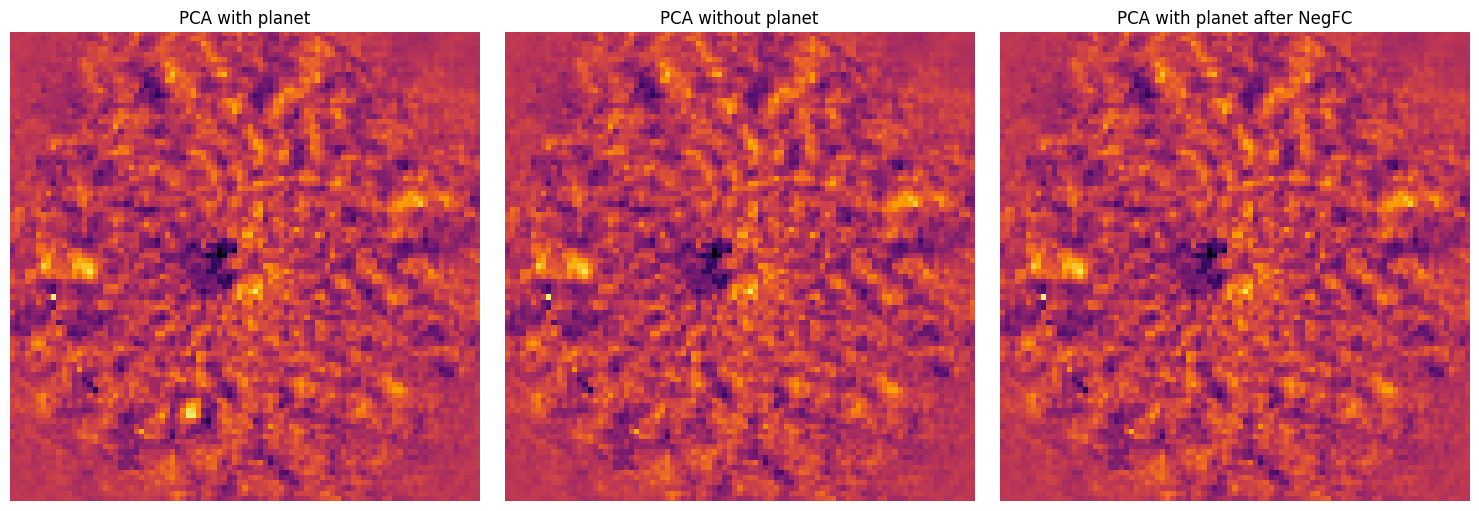

In [33]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.imshow(after_pca_with_planet.cpu().detach().numpy(), cmap="inferno", vmin=-0.5, vmax=0.5)
ax1.set_title("PCA with planet")
ax1.axis("off")

ax2.imshow(after_pca_without_planet.cpu().detach().numpy(), cmap="inferno", vmin=-0.5, vmax=0.5)
ax2.set_title("PCA without planet")
ax2.axis("off")

ax3.imshow(after_pca_neg_fc.cpu().detach().numpy(), cmap="inferno", vmin=-0.5, vmax=0.5)
ax3.set_title("PCA with planet after NegFC")
ax3.axis("off")

plt.tight_layout()

In [34]:
difference = after_pca_neg_fc.cpu().detach().numpy() - after_pca_without_planet.cpu().detach().numpy()

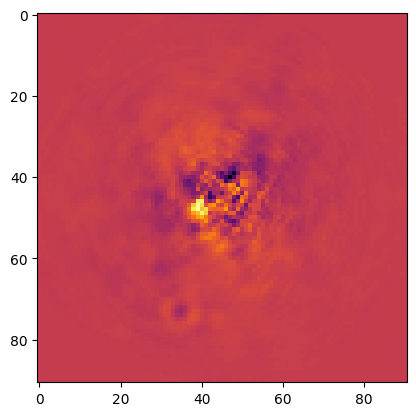

In [35]:
plt.imshow(difference, cmap="inferno")

In [18]:
np.max(difference)

0.00588274

In [19]:
np.max(np.abs(after_pca_with_planet.cpu().detach().numpy()))

570.2546

# Implement a simple minimization

In [20]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F


class NegFC(nn.Module):

    def __init__(
            self,
            psf_template,
            all_angles,
            input_size,
            init_separation,
            init_pos_angle,
            init_flux_ratio,
            dit_science,
            dit_psf_template,
            nd_factor,
            interpolation="bicubic"
    ):

        super(NegFC, self).__init__()
        self.m_input_size = input_size

        # initialize the three parameters
        self.pos_angle = nn.Parameter(torch.Tensor([init_pos_angle]))
        self.magnitude = nn.Parameter(torch.Tensor([flux_ratio2mag(init_flux_ratio)]))
        #self.flux_ratio = init_flux_ratio
        self.separation = nn.Parameter(torch.Tensor([init_separation]))
        self.interpolation = interpolation

        # the DIT and ND factor
        # TODO check if nd_factor is 1/nd_factor
        self.integration_time_factor = (
                dit_science / dit_psf_template * nd_factor)

        # save the angles
        self.register_buffer(
            "par_angles",
            torch.from_numpy(all_angles).float())

        # pad the psf template
        pad_size = (self.m_input_size - psf_template.shape[0]) // 2
        if pad_size < 0:
            raise ValueError(
                "The input size is smaller than the PSF template size")

        padded_psf = np.pad(
            psf_template,
            pad_width=((pad_size, pad_size), (pad_size, pad_size)),
            mode='constant',
            constant_values=0)

        self.register_buffer(
            "psf_template",
            torch.from_numpy(padded_psf).float())

    def get_forward_model(self):

        # calculate the correct position angle and x/y shifts
        ang = torch.deg2rad(self.pos_angle) + torch.pi / 2 - self.par_angles

        flux_ratio = 10 ** (-self.magnitude / 2.5)
        
        psf_torch = (self.psf_template *
                     flux_ratio *
                     self.integration_time_factor)

        x_shift = self.separation * torch.cos(ang)
        y_shift = self.separation * torch.sin(ang)

        # create the affine matrix
        theta = torch.zeros(ang.shape[0], 2, 3, device=ang.device)
        theta[:, 0, 0] = 1
        theta[:, 1, 1] = 1

        # the -1 is needed because the grid uses align_corners=True
        theta[:, 0, 2] = - x_shift / (psf_torch.shape[0] - 1) * 2
        theta[:, 1, 2] = - y_shift / (psf_torch.shape[1] - 1) * 2

        # build the grid
        grid = F.affine_grid(
            theta,
            torch.Size([ang.shape[0],
                        1,
                        self.m_input_size,
                        self.m_input_size]),
            align_corners=True)

        # apply the grid
        shifted_data = F.grid_sample(
            psf_torch.unsqueeze(0).unsqueeze(0).repeat(
                ang.shape[0], 1, 1, 1),
            grid,
            mode=self.interpolation,
            align_corners=True).squeeze()

        return shifted_data

    def forward(self, science_sequence):
        # get the forward model
        forward_model = self.get_forward_model()

        # apply the forward model
        return science_sequence - forward_model


In [29]:
import numpy as np

import torch
import torch.nn as nn

from fours.models.rotation import FieldRotationModel


class PCANoiseModel(nn.Module):

    def __init__(
            self,
            angles: np.ndarray,
            image_shape: int,
            pca_number: int,
            approx_svd: int = -1
    ):
        super(PCANoiseModel, self).__init__()

        # save the simple parameters
        self.m_pca_number = pca_number
        self.m_approx_svd = approx_svd
        self.m_image_shape = image_shape

        # create the rotation model
        self.rotation_model = FieldRotationModel(
            all_angles=angles,
            input_size=self.m_image_shape,
            subsample=1,
            inverse=False,
            register_grid=True)

        # create an empty basis
        self.register_buffer(
            "basis",
            torch.zeros(self.m_image_shape ** 2, self.m_pca_number))

    @staticmethod
    def _prepare_frames(
            images: torch.Tensor):
        # 1.) reshape images to fit for PCA
        images = images.view(images.shape[0],
                             images.shape[1] * images.shape[2])

        # 2.) remove the mean as needed for PCA
        images = images - images.mean(dim=0)

        return images

    def update_noise_model(
            self,
            images):
        # 1.) prepare the frames
        images = self._prepare_frames(images)

        # 2.) compute the PCA basis
        if self.m_approx_svd == -1:
            _, _, basis = torch.linalg.svd(images)
            basis = basis.T
        else:
            _, _, basis = torch.svd_lowrank(
                images, niter=1, q=self.m_approx_svd)

        # 3.) save the basis
        self.basis = basis.detach()

    def forward(self, images):
        # 1.) prepare the frames
        images = self._prepare_frames(images)

        # 2.) compute PCA residuals
        pca_rep = torch.matmul(images, self.basis[:, :self.m_pca_number])
        noise_estimate = torch.matmul(pca_rep,
                                      self.basis[:, :self.m_pca_number].T)
        residual = images - noise_estimate
        residual_sequence = residual.view(
            images.shape[0],
            self.m_image_shape,
            self.m_image_shape)

        # 3.) rotate the frames
        rotated_frames = self.rotation_model(
            residual_sequence.unsqueeze(1).float(),
            parang_idx=torch.arange(len(residual_sequence))).squeeze(1)

        # 4.) average along the time axis
        return rotated_frames.mean(dim=0)


In [50]:
pca_model = PCANoiseModel(
    angles=angles,
    image_shape=science_data.shape[1],
    pca_number=400,
    approx_svd=5000)

In [51]:
# create the NegFC model
negfc = NegFC(
    psf_template=psf_template,
    all_angles=angles,
    input_size=science_data.shape[1],
    init_separation=fake_planet_config["separation"] + 2,
    init_pos_angle=fake_planet_config["planet_position"][-1] - 4,
    init_flux_ratio=mag2flux_ratio(12.0),
    dit_science=dit_science,
    dit_psf_template=dit_psf_template,
    nd_factor=1.0,
    interpolation="bicubic",)

In [52]:
# move everything to the GPU
science_data_torch_with_planet = science_data_torch_with_planet.to(0)
negfc = negfc.to(0)
pca_model = pca_model.to(0)

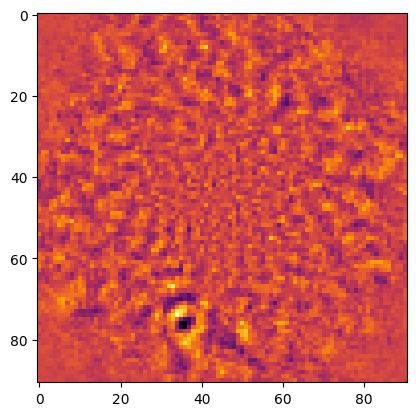

In [53]:
update_basis = True

after_negfc = negfc(science_data_torch_with_planet)

if update_basis:

    pca_model.update_noise_model(after_negfc)

after_pca_neg_fc = pca_model(after_negfc)
plt.imshow(after_pca_neg_fc.cpu().detach().numpy(), cmap="inferno")

In [54]:
from torch import optim
from tqdm import tqdm

In [55]:
input_data = science_data_torch_with_planet

# create the optimizer
optimizer_kwargs = {
    "max_iter": 20,
    "history_size": 10}

#optimizer_kwargs = {
 #   "lr": 1e-3}

optimizer = optim.LBFGS(
    negfc.parameters(),
    **optimizer_kwargs)

In [56]:
for j in range(20):
    print(negfc.separation.item(), negfc.pos_angle.item(), negfc.magnitude.item())
    after_negfc = negfc(science_data_torch_with_planet)
    pca_model.update_noise_model(after_negfc)

    # iterate for 100 steps
    for i in range(20):
        def closure():        
            optimizer.zero_grad()
            after_negfc = negfc(science_data_torch_with_planet)
            after_pca_neg_fc = pca_model(after_negfc)
            loss = torch.sum(after_pca_neg_fc**2)
            loss.backward()

            # print all parameters and the loss
            #print(negfc.separation.item(), np.rad2deg(negfc.pos_angle.item()), loss.item())
            return loss

        optimizer.step(closure)

32.0 16.0 12.0
31.81578826904297 16.410545349121094 12.364747047424316
31.441465377807617 17.209291458129883 12.630768775939941
30.946971893310547 18.264005661010742 12.664299011230469
30.56256675720215 19.01506805419922 12.523321151733398
30.346208572387695 19.390275955200195 12.370316505432129
30.222944259643555 19.5793399810791 12.257251739501953
30.147863388061523 19.679689407348633 12.179282188415527
30.100156784057617 19.735462188720703 12.126296043395996
30.068857192993164 19.76681900024414 12.090360641479492
30.04794692993164 19.78462791442871 12.066045761108398
30.033672332763672 19.796018600463867 12.049346923828125
30.023666381835938 19.801250457763672 12.0379056930542
30.016782760620117 19.806215286254883 12.030314445495605
30.011821746826172 19.808439254760742 12.024775505065918
30.008136749267578 19.807857513427734 12.020811080932617
30.006011962890625 19.810293197631836 12.018576622009277
30.004234313964844 19.81012535095215 12.016839027404785
30.002944946289062 19.81040

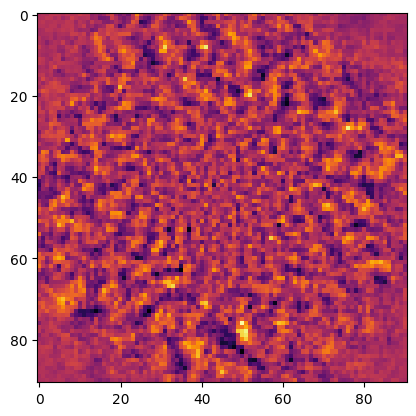

In [57]:
after_negfc = negfc(science_data_torch_with_planet)
after_pca_neg_fc = pca_model(after_negfc)
plt.imshow(after_pca_neg_fc.cpu().detach().numpy(), cmap="inferno")

In [58]:
negfc.separation.item()

30.00174903869629

In [59]:
negfc.pos_angle.item()

19.80962371826172

In [60]:
negfc.magnitude.item()

12.014311790466309

In [61]:
x_shift_res = negfc.separation.item() * np.cos(np.deg2rad(negfc.pos_angle.item()))
y_shift_res = negfc.separation.item() * np.sin(np.deg2rad(negfc.pos_angle.item()))

print(x_shift_res, y_shift_res)

28.226361318568056 10.16747127335793


In [62]:
x_shift = 30 * np.cos(np.deg2rad(20))
y_shift = 30 * np.sin(np.deg2rad(20))

print(x_shift, y_shift)

28.19077862357725 10.260604299770064


In [63]:
np.abs(y_shift - y_shift_res)

0.09313302641213284

In [64]:
np.abs(x_shift - x_shift_res)

0.035582694990807795

In [65]:
brightness_diff = np.abs(mag2flux_ratio(12.5) - mag2flux_ratio(negfc.magnitude.item()))

In [66]:
brightness_diff / mag2flux_ratio(12.5)

0.5641387803820636